# Generating trajectories
In this notebook we will generate a couple of interesting trajectories using the core `cmtj` library.


## First steps
Firstly, we import all the necessary stuff from `cmtj` library and we define a sphere on which we will be plotting our simulated magnetisation dyamics

In [1]:
import matplotlib.pyplot as plt
from cmtj import Junction, Layer, CVector, ScalarDriver, AxialDriver, NullDriver
import numpy as np
from typing import List, Dict
# sphere points
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0 * pi:100j]
x = r * sin(phi) * cos(theta)
y = r * sin(phi) * sin(theta)
z = r * cos(phi)


def plot_trajectory(log: Dict[str, List[float]], title: str):
    with plt.style.context(['science', 'no-latex']):
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        m = np.asarray([log[f'free_mx'], log[f'free_my'], log[f'free_mz']])
        ax.plot3D(m[0], m[1], m[2], color='blue')
        ax.set_axis_off()
        ax.plot_surface(x,
                        y,
                        z,
                        rstride=2,
                        cstride=2,
                        color='c',
                        alpha=0.3,
                        linewidth=0.1)
        ax.scatter([0], [0], [1], color='crimson', alpha=1.0, s=50)
        fig.savefig(f"{title}.png")


## STT trajectory
Our first trajectory will be the STO (Spin-Transfer Oscillator) trajectory. We will use the STT modelling to induce oscillations of the magnetisation. This is achieved by pumping spin current into our layer. The constant current density supplied to the system sustains the oscillations.

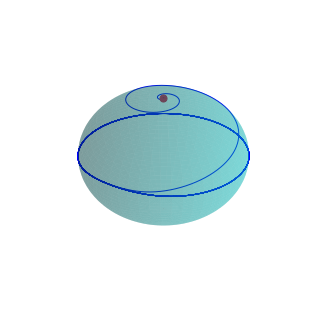

In [2]:
demagTensor = [CVector(0., 0., 0.), CVector(0., 0., 0.), CVector(0., 0., 1.0)]

damping = 0.3
currentDensity = 1e9
beta = 1
spinPolarisation = 1.0

l1 = Layer.createSTTLayer(id="free",
                          mag=CVector(0., 0., 1.),
                          anis=CVector(0, 0., 1.),
                          Ms=1.,
                          thickness=1.4e-9,
                          cellSurface=7e-10 * 7e-10,
                          demagTensor=demagTensor,
                          damping=damping,
                          SlonczewskiSpacerLayerParameter=1.0,
                          spinPolarisation=spinPolarisation,
                          beta=beta)

l1.setReferenceLayer(CVector(0, 1., 1.))
junction = Junction([l1])

junction.setLayerAnisotropyDriver("free",
                                  ScalarDriver.getConstantDriver(300e3))
junction.setLayerCurrentDriver("free",
                               ScalarDriver.getConstantDriver(currentDensity))

junction.runSimulation(150e-9, 1e-12, 1e-12, False, False)
log = junction.getLog()
plot_trajectory(log, "STT")


## VCMA trajectory

VCMA (Voltage Controlled Magnetic Anistoropy) allows us to control the perpendicular anisotropy of the system. Here, we excite the perpendicular anisotropy of our layer with a small sinusoidal anisotropy change in the z direction. Since we applied a strong magentic field in the y direction, the magnetisation will eventually settle there after being "popped" from a steady starting state in the z direction.

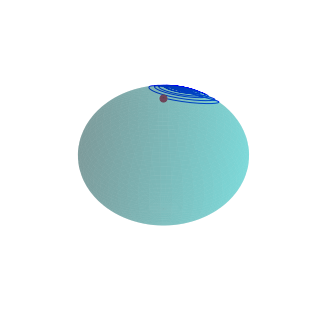

In [3]:
demagTensor = [CVector(0., 0., 0.), CVector(0., 0., 0.), CVector(0., 0., 1.0)]
damping = 0.03

l1 = Layer(id="free",
           mag=CVector(0., 0., 1.),
           anis=CVector(0, 0., 1.),
           Ms=1.2,
           thickness=1.4e-9,
           cellSurface=7e-10 * 7e-10,
           demagTensor=demagTensor,
           damping=damping)
junction = Junction([l1])

junction.setLayerExternalFieldDriver(
    "free",
    AxialDriver(NullDriver(), ScalarDriver.getConstantDriver(250e3),
                NullDriver()))
junction.setLayerAnisotropyDriver(
    "free", ScalarDriver.getSineDriver(900e3, 10e3, 7e9, 0))

junction.runSimulation(2e-9, 1e-12, 1e-12, False, False)
log = junction.getLog()
plot_trajectory(log, "VCMA")

## Oersted/ExternalField excitation

The idea is very similar to the VCMA, but here the excitation comes through the $H_{OE}$ (which in this case is modelled as an external field). You may use `setLayerOerstedFieldDriver` instead of `setLayerExternalFieldDriver` to help readability, but keep in mind that for the computational engine these two are identical.

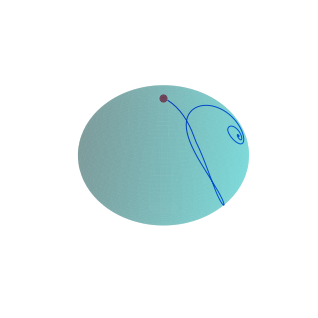

In [4]:
demagTensor = [CVector(0., 0., 0.), CVector(0., 0., 0.), CVector(0., 0., 1.0)]

damping = 0.3

l1 = Layer(id="free",
           mag=CVector(0., 0., 1.),
           anis=CVector(0, 0., 1.),
           Ms=1.6,
           thickness=1.4e-9,
           cellSurface=7e-10 * 7e-10,
           demagTensor=demagTensor,
           damping=damping)

junction = Junction([l1])

junction.setLayerExternalFieldDriver(
    "free",
    AxialDriver(ScalarDriver.getConstantDriver(200e3),
                ScalarDriver.getStepDriver(300e3, 100e3, 0.01e-9, 0.1e-9),
                NullDriver()))
junction.setLayerAnisotropyDriver("free",
                                  ScalarDriver.getConstantDriver(800e3))

junction.runSimulation(2e-9, 1e-12, 1e-12, False, False)
log = junction.getLog()
plot_trajectory(log, "Hoepulse")

## Bilayer switching

Finally, we will demonstrate the bilayer switching. Unlike in the other examples, we will use two layers since we need a pinning anisotropy in the bottom layer which is coupled to the top layer via the IEC interaction. The switching from parallel (initial) state to anti-parallel is achieved with STT, by supplying a sufficient spin current to the system.

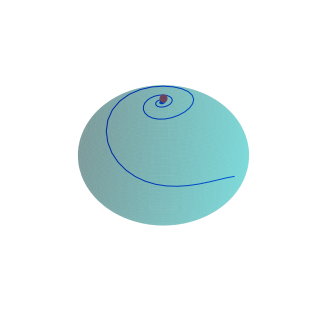

In [5]:
demagTensor = [CVector(0., 0., 0.), CVector(0., 0., 0.), CVector(0., 0., 1.)]

damping = 0.011

l1 = Layer.createSTTLayer(id="free",
                          mag=CVector(1., 0., 0.),
                          anis=CVector(1, 0., 0.),
                          Ms=1,
                          thickness=1.4e-9,
                          cellSurface=7e-10 * 7e-10,
                          demagTensor=demagTensor,
                          damping=damping,
                          SlonczewskiSpacerLayerParameter=1.0,
                          spinPolarisation=spinPolarisation,
                          beta=beta)
l2 = Layer.createSTTLayer(id="bottom",
                          mag=CVector(1., 0., 0.),
                          anis=CVector(1, 0., 0.),
                          Ms=1.2,
                          thickness=3e-9,
                          cellSurface=7e-10 * 7e-10,
                          demagTensor=demagTensor,
                          SlonczewskiSpacerLayerParameter=1.0,
                          spinPolarisation=spinPolarisation,
                          beta=beta)

l1.setReferenceLayer(CVector(0, 0, 1))
l2.setReferenceLayer(CVector(0, 0, 1))
junction = Junction([l1, l2])
junction.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(-4e-5))
junction.setLayerAnisotropyDriver("free",
                                  ScalarDriver.getConstantDriver(300e3))
junction.setLayerAnisotropyDriver("bottom",
                                  ScalarDriver.getConstantDriver(800e3))
junction.setLayerCurrentDriver("all", ScalarDriver.getConstantDriver(1e12))

junction.setLayerExternalFieldDriver(
    "free",
    AxialDriver(NullDriver(), ScalarDriver.getConstantDriver(100e3),
                NullDriver()))

junction.runSimulation(2e-9, 1e-12, 1e-12, False, False)
log = junction.getLog()
plot_trajectory(log, "Switching")